# Analyzing IICW3C logs
python environment, functions, and examples
<br>
7/27/23
<br>

## environment
- use conda to clone the environment stored in `environment.yml`
    ```
    conda env create -f environment.yml
    conda activate iisw3c-tool
    ```

- if using this notebook, set the kernel to 'parse-iis'

- you will also need a `.env` file with credentials for the `geoip2` geocoder, represented as a key stored under `GEOAPI2_KEY` and an account id stored under `GEOIP2_AID`. you can set up a free account [here](maxmind.com/en/geoip2-databases). the `.env` should also contain `LOG_LOCATION`, representing a file path where logs (.log files) are stored in folders for each month.

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import warnings
import numpy as np
import requests as r
import pprint
import time
import pandas as pd
warnings.simplefilter(
    action='ignore', category=pd.errors.SettingWithCopyWarning
    )
from geoip2 import webservice, errors
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
from user_agents import parse

if load_dotenv():
    print('env variables loaded')

logfile_location = os.getenv('LOG_LOCATION')

env variables loaded


## functions
Use these functions to access and analyze data stored in local log files. Recommend first developing analysis on a single log, then expanding it to target the month or set of months.

In [14]:
def log_to_df(
        log_path:str,
        fields:list=['date', 'time', 's-ip', 'cs-method', 'cs-uri-stem', 'cs-uri-query', 's-port', 'cs-username', 'c-ip', 'cs(User-Agent)', 'cs(Referer)', 'sc-status', 'sc-substatus', 'sc-win32-status', 'sc-bytes', 'time-taken']
        ):
    """
    loads a log file into a pandas dataframe
    """
    # Read the log file into a DataFrame
    df = pd.read_csv(log_path, sep=' ', header=None, names=fields, skiprows=4)

    # add a unique ID to dataframe so it can be cut into subsets
    df['uid'] = range(1, len(df) + 1)

    return df

def logs_to_df(
        folder_path:str,
        fields:list=['date', 'time', 's-ip', 'cs-method', 'cs-uri-stem', 'cs-uri-query', 's-port', 'cs-username', 'c-ip', 'cs(User-Agent)', 'cs(Referer)', 'sc-status', 'sc-substatus', 'sc-win32-status', 'sc-bytes', 'time-taken'],
        filter_mm_rlis=False):
    """
    loads a folder of log files into a single pandas dataframe. all log files must have the same fields, and follow the ISSW3C spec.
    """
    start = time.time()

    # initialize list for per-log dataframes, later flattened
    dfs = []

    # for each log file in the target folder,
    for file in os.listdir(folder_path):
        if file.endswith('.log'):
            print(f'\t\tloading {file} to dataframe')
            log = os.path.join(folder_path, file)
            
            # read it into a dataframe (ignore 1st 4 lines, in keeping with ISSW3C format)
            # add it to the list
            if filter_mm_rlis:
                df = filter_metromaps_rlis(
                    pd.read_csv(log, sep=' ', header=None, names=fields, skiprows=4)
                )
            else:
                df = pd.read_csv(log, sep=' ', header=None, names=fields, skiprows=4)

            dfs.append(df)
            # print(file, "read successfully")

    # flatten the list
    folder_df = pd.concat(dfs, axis=0, ignore_index=True)

    # add a unique ID to dataframe so it can be cut into subsets
    folder_df['uid'] = range(1, len(folder_df) + 1)


    print(f'took {time.time() - start} sec')
    return folder_df

def geocode_ip(dataframe: pd.DataFrame, sample_size: int = 100):
    """
    returns a geodataframe of points representing IP addresses from the dataframe passed.
    Works well with a df that's already grouped by IP address, to maximize the number of unique IPs sampled and geocoded.
    only 1000 requests/day are permitted; consider upgrading to a paid svc 
    """
    # geocoder api stuff
    key = os.getenv('GEOIP2_KEY') # api key
    aid = os.getenv('GEOIP2_AID') # acc id

    # get every nth record to reduce burden on geocoder
    subset = dataframe.sample(n=sample_size)
    subset['lat'] = ""
    subset['lon'] = ""
    subset['reserved_ip'] = False

    # for each row, geocode its ip
    with webservice.Client(aid, key, host='geolite.info') as client:
        for row_index, row in subset.iterrows():
            try:
                response = client.city(row['c-ip'])
                lon = response.location.longitude
                lat = response.location.latitude
                subset.loc[row_index, ['lon', 'lat']] = [lon, lat]
            except errors.AddressNotFoundError:
                subset.loc[row_index, 'reserved_ip'] = True

    spatial_subset = subset[subset['reserved_ip'] == False]
    geo = [
        Point(lon, lat) for
            lon, lat in 
                zip(
                    spatial_subset['lon'],
                    spatial_subset['lat']
                )]
    
    return gpd.GeoDataFrame(spatial_subset, geometry=geo)


def parse_user_agent(user_agent):
    """
    parses a user agent string
    """
    ua = parse(user_agent)
    
    device = {
        'brand': ua.device.brand,
        'model': ua.device.model,
        'os': f'{ua.os.family} {ua.os.version_string}'
    }
    
    browser = {
        'family': ua.browser.family,
        'version': ua.browser.version_string
    }
    
    is_bot = any(keyword in user_agent.lower() for keyword in ['bot', 'crawler', 'spider'])
    
    return {
        'agent_str': user_agent,
        'device': device,
        'browser': browser,
        'is_bot': is_bot
    }


def batch_stats(function, log_dir=fr'{logfile_location}', just_mm_rlis=False):
    """
    iteratively applies a function with dict output to every month in the log folder, reporting results. expects resuts
    """

    for i in os.listdir(log_dir):
        print(i)
        if i.endswith('.zip') or i.endswith('.txt'):
            pass
        else:
            # make the log for the month
            month = logs_to_df(os.path.join(log_dir, i), filter_mm_rlis=just_mm_rlis)

            # get and view ip stats
            stats = function(month)
            print(
                i.split('/')[-1],
                pprint.pformat(stats)
            )
            month = None
            print('__________________________________________')

def ip_request_statistics(dataframe:pd.DataFrame, use_log=True):
    """
    computes mean, standard deviation of request counts by IP,
    and gives z-score of most prolific IP (base-2 logarithm-transformed if use_log==True),
    for the dataframe passed
    """
    # Calculate the request count per IP address (log-transformed)
    request_counts = dataframe['c-ip'].value_counts()
    if use_log:
        request_counts = np.log2(
            request_counts
        )
        

    # Calculate the mean and standard deviation of request counts
    mean_requests = request_counts.mean()
    std_requests = request_counts.std()

    # Identify the most prolific IP address
    most_prolific_ip = request_counts.idxmax()

    # Calculate the z-score for the most prolific IP address
    z_score = (request_counts[most_prolific_ip] - mean_requests) / std_requests

    return {
        # the mean number of requests coming from a single IP
        'mean_request_count': mean_requests,

        # the dispersion of the above
        'stdev_request_count': std_requests,

        # top 10 most prolific IP addresses
        'top_10': list(dataframe['c-ip'].value_counts().head(10).index),

        # the number of unique IP addresses
        'n_unique': dataframe['c-ip'].nunique(),

        # address, request count, and z-score (prominence) of most prolific IP in the dataframe
        'top': {
            'address': most_prolific_ip,
            'request_count': request_counts.max(),
            'z_score': z_score
        },

        # wether or not these statistics come from logarithm-transformed data
        'used_log': use_log
    }

def filter_services(dataframe):
    '''
    metro-specific: get insights on /services/ endpoints that aren't from ArcGIS rest and are referred froim metromaps referrers
    '''
    return dataframe[
    (dataframe['cs(Referer)'].str.contains('metromap')) &
    (dataframe['cs-uri-stem'].str.contains('/services/')) &
    (~dataframe['cs-uri-stem'].str.contains('/ArcGIS/')) &
    (~dataframe['cs-uri-stem'].str.contains('/arcgis/'))
    ]

def parse_uri_stem(row):
    '''
    used in append_uri_path to break apart URI stem into a list, given a series with appropriate stem field'''
    path = row['cs-uri-stem']
    if pd.isnull(path):
        return [None, None, None, None]
    else:
        split_values = path.split('/')
        if len(split_values) >= 5:
            return split_values[:5]
        else:
            split_values += [None] * (5 - len(split_values))
            return split_values
        
def append_uri_path(dataframe):
    '''
    appends first 5 elements of a uri stem as separate fields to the end of a dataframe, for each row
    '''

    # Apply parse_uri_stem function to 'cs-uri-stem' column and store the results
    split_values = dataframe.apply(parse_uri_stem, axis=1)

    # Create new columns for the first five values in the split_values DataFrame
    dataframe['1st_value'] = split_values.apply(lambda x: x[0])
    dataframe['2nd_value'] = split_values.apply(lambda x: x[1])
    dataframe['3rd_value'] = split_values.apply(lambda x: x[2])
    dataframe['4th_value'] = split_values.apply(lambda x: x[3])
    dataframe['5th_value'] = split_values.apply(lambda x: x[4])
    
    return dataframe

def filter_metromaps_rlis(dataframe):
    return dataframe[
    (dataframe['cs-uri-stem'].str.contains('rlisapi')) & (dataframe['cs(Referer)'].str.contains('metromap'))
    ]

def user_agent_statistics(dataframe:pd.DataFrame, use_log:bool=True):
    """
    looks at the distribution and characteristics of User Agent info,
    and gives z-score of most prolific IP (base-2 logarithm-transformed if use_log)
    """
    # Calculate the request count per IP address (log-transformed)
    user_agent_counts = dataframe['cs(User-Agent)'].value_counts()
    # print('user agent counts\n', user_agent_counts)
    if use_log:
        user_agent_counts = np.log2(
            user_agent_counts
        )
        

    # calculate the average number of requests associated with a distinct user agent
    mean_requests = user_agent_counts.mean()

    # get dispersion of that statistic via stdev
    std_requests = user_agent_counts.std()

    # Identify the most common user agent (TODO: generalize by browser or ???)
    most_prolific_ua = user_agent_counts.idxmax()

    # Calculate the z-score for the most common user agent
    z_score = (user_agent_counts[most_prolific_ua] - mean_requests) / std_requests

    # check for suspish user agent strings
    top10 = []
    for agent in list(user_agent_counts.head(10).index):
        top10.append(parse_user_agent(agent))

    return {
        # average number of requests associated with a distinct user agent
        'mean_request_count': mean_requests,

        # dispersion of that statistic via stdev
        'stdev_request_count': std_requests,

        # top 10 user agents
        'top_10': top10,
        'n_unique': dataframe['c-ip'].nunique(),
        'top': {
            'user_agent': most_prolific_ua,
            'request_count': user_agent_counts.max(),
            'z_score': z_score
        },
        'used_log': use_log
    }

# function to append browser to each request
def extract_browser(user_agent):
    parsed_agent = parse(user_agent)
    return parsed_agent.browser.family


# function to append os to each request
def extract_os(user_agent):
    parsed_agent = parse(user_agent)
    return parsed_agent.os.family


def check_svc_layer(dataframe):

    svcs = filter_services(dataframe)
    svcs_parsed = append_uri_path(svcs)

    return {
        '3rd value counts': svcs_parsed['3rd_value'].value_counts(),
        '4th value counts': svcs_parsed['4th_value'].value_counts()
    }

def ua_stats_simple(dataframe:pd.DataFrame, n_classes:int=10):
    """
    this function takes a log file dataframe,
    and produces a dict containing the coutns of the n top browsers and oss,
    according to the n_classes parameter. It also gives a count/proportion
    of bots and mobile useres.
    """

    total = len(dataframe)

    # add some user-agent fields (log, os) to each record in the dataframe
    dataframe['browser'] = dataframe['cs(User-Agent)'].apply(extract_browser)
    dataframe['os'] = dataframe['cs(User-Agent)'].apply(extract_os)

    n_bots = len(dataframe[
        dataframe['browser'].str.contains('bot') |
        dataframe['browser'].str.contains('Bot') |
        dataframe['browser'].str.contains('Peeker') |
        dataframe['browser'].str.contains('peeker') |
        dataframe['browser'].str.contains('Crawler') |
        dataframe['browser'].str.contains('crawler') |
        dataframe['browser'].str.contains('Spider') |
        dataframe['browser'].str.contains('spider')
        ])
    
    # NOTE: mobile # is inferred from browser, not OS.
    n_mobile = len(dataframe[
        dataframe['browser'].str.contains('mobile') |
        dataframe['browser'].str.contains('Mobile') |
        dataframe['browser'].str.contains('Snapchat') |
        dataframe['browser'].str.contains('snapchat') |
        dataframe['browser'].str.contains('Instagram') |
        dataframe['browser'].str.contains('instagram')
        ])
    
    top_browsers = dataframe.value_counts(['browser']).head(n_classes)
    top_oss = dataframe.value_counts(['os']).head(n_classes)

    # add # of browser/oss not represented by top n browser/os types to the Other category
    if 'Other' in top_browsers:
        top_browsers['Other'] += len(dataframe) - sum(top_browsers)
    else:
        print('Other not present in top rbwoser')
        top_browsers['Other'] = len(dataframe) - sum(top_browsers)

    if 'Other' in top_oss:
        top_oss['Other'] += len(dataframe) - sum(top_oss)
    else:
        print('Other not present in top os')
        top_oss['Other'] = len(dataframe) - sum(top_oss)
    return {
        'top_browsers': top_browsers,
        'top_oss': top_oss,
        'bot_info': {
            'count': n_bots,
            'prop': n_bots/total
        },
        'mobile_info': {
            'count': n_mobile,
            'prop': n_mobile/total
        }
    }

## examples

### example: view and visualize request statistics by IP in a log file

In [5]:
# load log file for a given day
oct4 = log_to_df(os.path.join(logfile_location, '202210/u_ex221004.log'))

# get and view IP statistics (logarithm-transformed)
stats = ip_request_statistics(oct4)
print(
    pprint.pformat(stats)
)

{'mean_request_count': 3.493246446838121,
 'n_unique': 3803,
 'stdev_request_count': 2.563869950055888,
 'top': {'address': '52.205.137.89',
         'request_count': 14.928287036957299,
         'z_score': 4.460070445410039},
 'top_10': ['52.205.137.89',
            '34.234.176.30',
            '34.233.233.138',
            '208.71.202.129',
            '204.147.152.14',
            '204.147.152.5',
            '10.80.101.81',
            '67.160.140.19',
            '10.80.101.208',
            '205.173.217.10'],
 'used_log': True}


In [6]:
# filter to show instances of the RLIS api  being targeted by metromaps referrers
oc4_mm = oct4[
    (oct4['cs-uri-stem'].str.contains('rlisapi')) & (oct4['cs(Referer)'].str.contains('metromap'))
    ]
oc4_mm['cs-uri-stem']



3581                 /rlisapi2/js/
5126                 /rlisapi2/js/
5321      /rlisapi2/GetSuggestion/
5322      /rlisapi2/GetSuggestion/
5323      /rlisapi2/GetSuggestion/
                    ...           
541566       /rlisapi2/QueryPoint/
541596     /rlisapi2/queryAddress/
542019     /rlisapi2/queryAddress/
542227     /rlisapi2/queryAddress/
547138               /rlisapi2/js/
Name: cs-uri-stem, Length: 8553, dtype: object

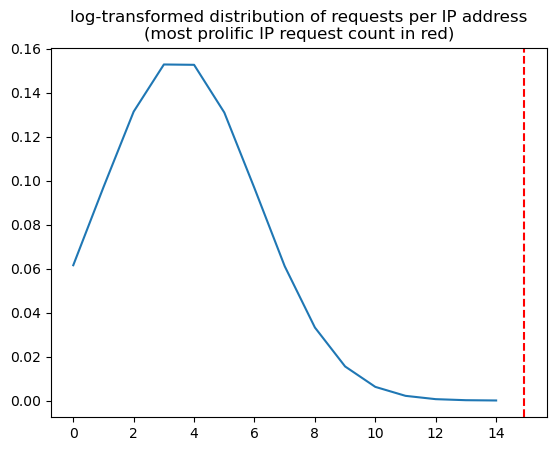

In [7]:
# get a a depiction of how prominent the most popular IP address is
# visualize the distribution of requests per IP, using numpy and matplotlib
x_axis = np.arange(
    0,
    stats['top']['request_count']
)

plt.plot(
    x_axis,
    norm.pdf(x_axis, stats['mean_request_count'],
             stats['stdev_request_count'])
)

plt.title('log-transformed distribution of requests per IP address\n(most prolific IP request count in red)')

# add most prolific IP as a red line
plt.axvline(x=stats['top']['request_count'], color='r', linestyle='--')

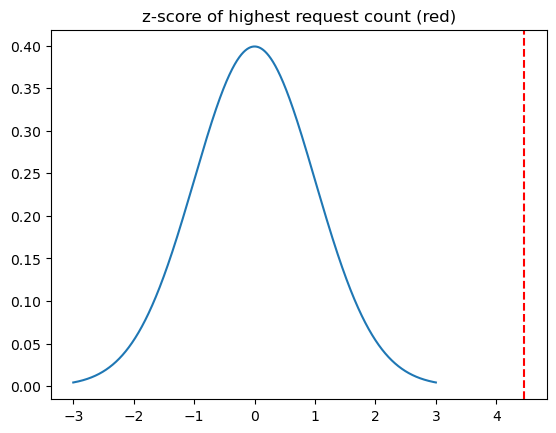

In [8]:
# standardize the distribution to look at z-score
x_axis = np.arange(-3, 3, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.title('z-score of highest request count (red)')

# adding z-score, in this case to a similar effect
plt.axvline(x=stats['top']['z_score'], color='r', linestyle='--')

### example: view geographic distribution of users

C:\Users\sgartrel\AppData\Local\Temp\ipykernel_25712\447517926.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


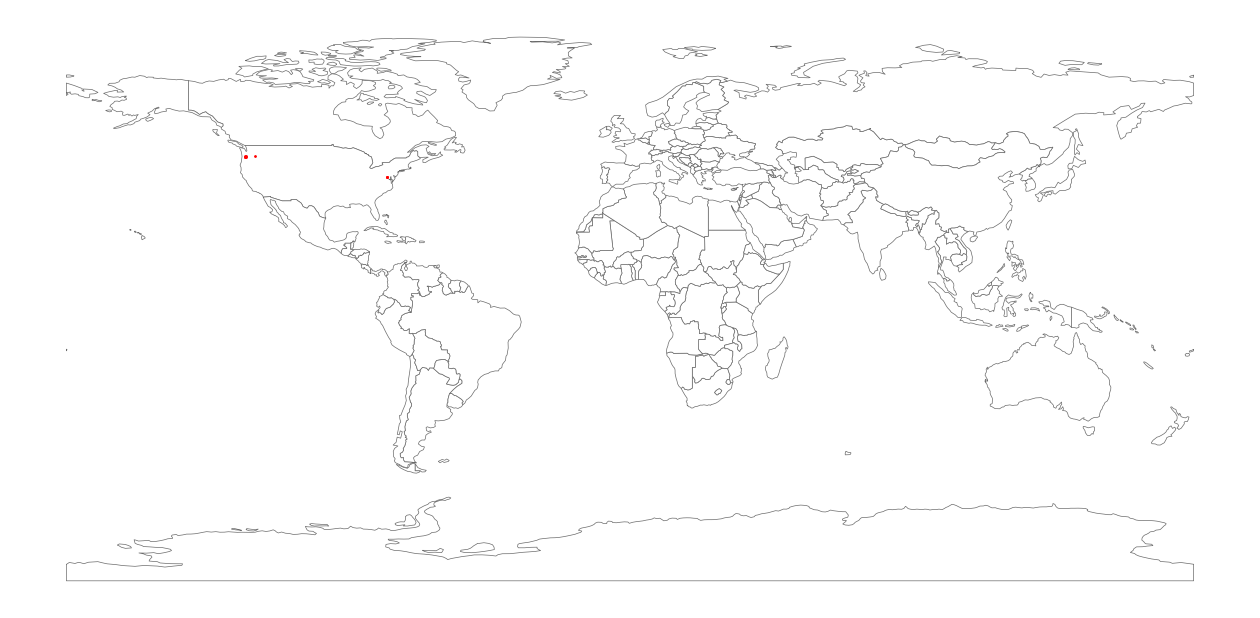

In [9]:
# geocode a subset of requests in the IIS log dataframe
# (NOTE: current geoip2 plan only allows 1000 request per day)
oct4_geocoded = geocode_ip(oct4, sample_size=10)
fig, ax = plt.subplots(figsize=(16, 16))

# fyi this dataset was deprecated 2023
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.plot(ax=ax, color='#ffffff', edgecolor='#6a6a6a', linewidth=.5)
oct4_geocoded.plot(ax=ax, color='red', markersize=1)
_=ax.axis('off')

# Show the plot
plt.show()

### example: get average number of hits for each unique URI prefix


In [24]:
# read through csv of common uri-stem prefixes, 
# get the average number of hits for each prefix
folder_path = r'd:/metro/scripts/IISW3C-parse-tools/ua-by-uri/'

dataframes = []

# Read each CSV file and create dataframes
for filename in os.listdir(folder_path):
    print(filename)
    if filename.endswith('.CSV'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, names=['Hits', 'Prefix'], skiprows=1)
        dataframes.append(df)

merged_df = pd.concat(dataframes).groupby('Prefix').mean().reset_index()

final = merged_df[merged_df['Hits'] > 10]

# this targets '/services/*', excluding arcgis-hosted stuff
services = merged_df[
    (merged_df['Prefix'].str.contains('/services/')) &
    ~(merged_df['Prefix'].str.contains('ArcGIS')) &
    ~(merged_df['Prefix'].str.contains('arcgis'))
    ]

out = services.sort_values('Hits', ascending=False).reset_index()

out.to_csv('avg_hits_per_2prefix.csv', index=False)

2210_trunks_activity.CSV
2211_trunks_activity.CSV
2212_trunks_activity.CSV
2301_trunks_activity.CSV
2302_trunks_activity.CSV
2303_trunks_activity.CSV
2304_trunks_activity.CSV


In [44]:
# view most common browser for major URI prefixes
log_data = log_to_df(r'd:/metro/logs/202210/u_ex221004.log')
log_data = log_data[log_data['cs(Referer)'].str.contains('metromap')]
# list of 2-folder URI prefixes
prefixes = ['/rlisapi2/getsuggestion', '/arcgis/rest', '/metromap/img', '/rlisapi2/queryaddress', '/rlisapi2/js', '/assets/img', '/assets/fonts', '/metromap/js', '/services/taxlots', '/metromap/fonts', '/metromap/css', '/services/2ftcontours', '/rlisapi2/querypoint', '/services/citybounds', '/services/land', '/services/metrobounds', '/services/slope25', '/services/wetlands', '/services/riparianhabitat', '/services/floodplain', '/services/ugb', '/metromap/printserver.ashx', '/services/orca_parksandnaturalareas', '/services/slope10', '/services/sewerdistricts', '/services/uplandhabitat', '/services/reserves', '/authentication/js', '/services/haulers', '/metromap/print', '/services/boundary', '/services/vacantlands2013',
            '/services/neighborhoods', '/services/councildistrict', '/services/trailsexisting', '/services/firedistricts', '/services/schooldistricts', '/services/waterdistrict', '/services/sectionlines', '/rlisapi2/searchtaxlotid', '/favicon.ico', '/services/zoning', '/services/orca_schools', '/services/transitdistrict', '/services/voterprecincts', '/services/lrt', '/services/orca_cemeteries', '/services/multifamily', '/services/orca_hoas', '/services/parkdistricts', '/services/orca_other', '/services/censustracts', '/metromap/', '/metromap/help.htm', '/services/orca_golfcourses', '/authentication/', '/metromap/embed', '/metromap/feedback.ashx', '/rlisapi2/searchtaxlotowner', '/historic_photo_viewer']

for p in prefixes:
    df = log_data[log_data['cs-uri-stem'].str.startswith(p)]
    if len(df) > 0:
        print(f'\n\n___{p} USER AGENT INFO___\n')
        pprint.pprint(user_agent_statistics(df))
        print('____________________________________________')



___/arcgis/rest USER AGENT INFO___

{'mean_request_count': 2.4921827213047814,
 'n_unique': 157,
 'stdev_request_count': 2.442736831338038,
 'top': {'request_count': 8.092757140919852,
         'user_agent': 'Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/105.0.0.0+Safari/537.36',
         'z_score': 2.292745721833363},
 'top_10': [{'agent_str': 'Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/105.0.0.0+Safari/537.36',
             'browser': {'family': 'Chrome', 'version': '105.0.0'},
             'device': {'brand': None, 'model': None, 'os': 'Windows '},
             'is_bot': False},
            {'agent_str': 'Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/106.0.0.0+Safari/537.36',
             'browser': {'family': 'Chrome', 'version': '106.0.0'},
             'device': {'brand': None, 'model': None, 'os': 'Windows '},
             'is_bot': False},
         

### example: view layers at /services/ referred by metromap, ranked by usage

In [15]:
def mm_referred_gislayers(df):
    svcs = df[
    (df['cs-uri-stem'].str.startswith('/services/')) &
    (df['cs(Referer)'].str.contains('metromap'))
    ]
    svcs_no_arc = svcs[
    ~(svcs['cs(Referer)'].str.contains('ArcGIS')) &
    ~(svcs['cs(Referer)'].str.contains('arcgis'))
    ]
    svcs_parsed = append_uri_path(svcs)
    svcs_no_arc_parsed = append_uri_path(svcs_no_arc)
    print('incl. arcgis referrers:\n', svcs_parsed.value_counts(['3rd_value']), '\n\n')
    print('not incl. arcgis referrers:\n', svcs_no_arc_parsed.value_counts(['3rd_value']), '\n\n')

batch_stats(mm_referred_gislayers)


202210.zip
202211.zip
202302.zip
202303.zip
202304.zip
drive-download-20230623T201911Z-001.zip
202210
		loading u_ex221001.log to dataframe
		loading u_ex221002.log to dataframe
		loading u_ex221003.log to dataframe


KeyboardInterrupt: 

### example: get and export user agent statistics to csv for visualization in Google Sheets

In [18]:
# make a loop that gets user agent data for all time
# takes 20 mins
ua_dicts = []
folders = [
    os.path.join(logfile_location, '202210'),
    os.path.join(logfile_location, '202211'),
    os.path.join(logfile_location, '202212'),
    os.path.join(logfile_location, '202301'),
    os.path.join(logfile_location, '202302'),
    os.path.join(logfile_location, '202303'),
    os.path.join(logfile_location, '202304'),
]

for folder in folders:
    logf = logs_to_df(folder)

    # filter to target actual user visits to the metromap site 
    actual_visits = logf[logf['cs-uri-stem'].str.contains('/metromap/js/script.min.js')]
    logf = None

    # get stats and append to list
    ua_dicts.append(ua_stats_simple(actual_visits))
    actual_visits = None
    

ua_dicts


		loading u_ex221001.log to dataframe
		loading u_ex221002.log to dataframe
		loading u_ex221003.log to dataframe
		loading u_ex221004.log to dataframe
		loading u_ex221005.log to dataframe
		loading u_ex221006.log to dataframe
		loading u_ex221007.log to dataframe
		loading u_ex221008.log to dataframe
		loading u_ex221009.log to dataframe
		loading u_ex221010.log to dataframe
		loading u_ex221011.log to dataframe
		loading u_ex221012.log to dataframe
		loading u_ex221013.log to dataframe
		loading u_ex221014.log to dataframe
		loading u_ex221015.log to dataframe
		loading u_ex221016.log to dataframe
		loading u_ex221017.log to dataframe
		loading u_ex221018.log to dataframe
		loading u_ex221019.log to dataframe
		loading u_ex221020.log to dataframe
		loading u_ex221021.log to dataframe
		loading u_ex221022.log to dataframe
		loading u_ex221023.log to dataframe
		loading u_ex221024.log to dataframe
		loading u_ex221025.log to dataframe
		loading u_ex221026.log to dataframe
		loading u_

[{'top_browsers': browser          
  Chrome               2770
  Edge                  674
  Firefox               475
  Mobile Safari         149
  IE                    137
  Safari                128
  Chrome Mobile iOS      29
  bingbot                27
  Googlebot              10
  DuckDuckGo Mobile       9
  Other                  55
  Name: count, dtype: int64,
  'top_oss': os      
  Windows     3711
  Mac OS X     374
  iOS          195
  Android       95
  Other         53
  Linux         22
  Ubuntu        13
  Name: count, dtype: int64,
  'bot_info': {'count': 49, 'prop': 0.010979161998655613},
  'mobile_info': {'count': 208, 'prop': 0.04660542236164015}},
 {'top_browsers': browser          
  Chrome               2375
  Edge                  598
  Firefox               505
  Mobile Safari         164
  IE                    127
  Safari                117
  AhrefsBot              47
  bingbot                34
  Chrome Mobile iOS      23
  DuckDuckGo Mobile       7
  Oth

In [19]:
# convert ua_dicts into a csv representing all-time UA stats
# Collapse the list of dictionaries into a single DataFrame
# Extract operating system counts and export to a CSV file
os_counts = pd.concat([data['top_oss'] for data in ua_dicts]).groupby(level=0).sum()
os_counts.to_csv('operating_system_counts.csv')

# Extract browser counts and export to a CSV file
browser_counts = pd.concat([data['top_browsers'] for data in ua_dicts]).groupby(level=0).sum()
browser_counts.to_csv('browser_counts.csv')

# Extract bot information and export to a CSV file
bot_info = pd.DataFrame([{'Bots Count': data['bot_info']['count'], 'Proportion': data['bot_info']['prop']} for data in ua_dicts])
bot_info.to_csv('bot_info.csv')

### example: delete weekends from a csv of daily hitcounts
data for this example is extracted from the following logparser query and stored as csv in folders called `internal_counts` and `total_counts`. The CSVs are named by mo th, with October 2022 as 2210, January 2023 as 2301, etc.

```
/*  New Query  */
SELECT TO_LOCALTIME(QUANTIZE(TO_TIMESTAMP(date, time), 3600)) AS [Hour],
         COUNT(*) AS [Requests]
    FROM '[LOGFILEPATH]'
WHERE (cs-uri-stem = '/metromap/js/script.min.js') and (
c-ip LIKE '10.%'
OR c-ip LIKE '172.16.%'
OR c-ip LIKE '172.17.%'
OR c-ip LIKE '172.18.%'
OR c-ip LIKE '172.19.%'
OR c-ip LIKE '172.2%.'
OR c-ip LIKE '172.30.%'
OR c-ip LIKE '172.31.%'
OR c-ip LIKE '192.168.%'
)

GROUP BY Hour
ORDER BY Hour
```

In [20]:
from datetime import datetime

def is_weekday(csv_row:str, col_num:int, date_format:str='%m/%d/%Y %I:%M:%S %p', delim='\t'):
    """
    checks the timestamp a string (delimiter speciifed by delim param),
    located via index speficied in the col_num parameter,
    and reports wether or not it's a weekday
    """
    # get timestamp
    ts = datetime.strptime(
        csv_row.split(delim)[col_num],
        date_format
    )

    # monday = 1, friday = 4
    if ts.weekday() < 5:
        return True
    return False

In [21]:
# get average hits for non-weekdays
def avg_hits_weekdays(location:str):
    weekday_counts = {}
    with open(location, 'r') as counts:
        for line in counts:
            if line.split('\t')[1].startswith('Hour'):
                pass

            elif is_weekday(line, 1):
                # it will be formatted like 
                # 2/8/2023 1:00:00 PM
                vals = line.split('\t')
                time = vals[1].split(' ')[1:3]
                hour = time[0] + ' ' + time[1]
                if hour not in weekday_counts.keys():
                    weekday_counts[hour] = []
                weekday_counts[hour].append(int(vals[2].strip('\n')))
    print(f'daily hits for {location}:\n\t', weekday_counts, '\n')
    return weekday_counts

In [22]:
hours = [
    '12:00:00 AM',
    '1:00:00 AM',
    '2:00:00 AM',
    '3:00:00 AM',
    '4:00:00 AM',
    '5:00:00 AM',
    '6:00:00 AM',
    '7:00:00 AM',
    '8:00:00 AM',
    '9:00:00 AM',
    '10:00:00 AM',
    '11:00:00 AM',
    '12:00:00 PM',
    '1:00:00 PM',
    '2:00:00 PM',
    '3:00:00 PM',
    '4:00:00 PM',
    '5:00:00 PM',
    '6:00:00 PM',
    '7:00:00 PM',
    '8:00:00 PM',
    '9:00:00 PM',
    '10:00:00 PM',
    '11:00:00 PM'
]
month_dfs = {}

# for each month,
for month in os.listdir('./internal_counts'):
    hit_data = {}
    hit_data['internal'] = avg_hits_weekdays(f'./internal_counts/{month}')
    hit_data['total'] = avg_hits_weekdays(f'./total_counts/{month}')

    # get a dataframe whose index is hour (from 0000 to 2400)
    # with columns for internal and total traffic, at hourly intervals
    hourly = pd.DataFrame()
    hourly.index = hours
    
    # populate the dataframe with data from the weekdays function
    for hour in hours:
        for i in ['internal', 'total']:
            try:
                hourly.loc[hour, f'{i}'] = round(np.sum(hit_data[i][hour]), 2)
                # hourly.loc[hour, f'{i} mean'] = round(np.mean(hit_data[i][hour]), 2)

            except KeyError:
                hourly.loc[hour, f'{i}'] = np.nan
                # hourly.loc[hour, f'{i} mean'] = np.nan

    # add a final row representing to the total average number of internal/total hits in that 12 hour period.
    month_dfs[month.strip('.csv')] = hourly
    hourly = None

daily hits for ./internal_counts/2210.csv:
	 {'3:00:00 PM': [1, 1, 2, 1, 1, 1, 1, 1], '10:00:00 AM': [1, 1, 1, 1], '1:00:00 PM': [1, 1, 1, 1, 1, 1, 1], '7:00:00 AM': [1, 2], '12:00:00 PM': [1, 1, 1], '2:00:00 PM': [1, 1, 1, 1], '11:00:00 AM': [1, 1, 1], '8:00:00 AM': [2, 1, 2, 1, 1, 1], '9:00:00 AM': [3, 1, 1, 1], '4:00:00 PM': [1], '12:00:00 AM': [1], '9:00:00 PM': [1]} 

daily hits for ./total_counts/2210.csv:
	 {'12:00:00 AM': [1, 2, 2, 1, 2, 2, 1, 2, 1, 1], '6:00:00 AM': [6, 3, 2, 4, 1, 4, 2, 4, 2, 2, 4, 2, 2, 2, 3, 2, 2, 2, 2], '7:00:00 AM': [8, 9, 11, 5, 4, 3, 9, 9, 10, 8, 5, 7, 6, 7, 4, 7, 6, 6, 10, 5, 8], '8:00:00 AM': [11, 13, 20, 11, 16, 19, 15, 14, 21, 15, 18, 16, 12, 14, 16, 13, 14, 14, 19, 8, 12], '9:00:00 AM': [24, 17, 21, 9, 13, 19, 29, 13, 14, 14, 30, 15, 33, 21, 19, 18, 21, 23, 16, 15, 20], '10:00:00 AM': [15, 21, 19, 23, 14, 22, 23, 26, 17, 12, 26, 24, 8, 14, 12, 21, 19, 19, 21, 22, 9], '11:00:00 AM': [22, 12, 13, 28, 16, 19, 22, 17, 16, 14, 19, 22, 16, 19, 12, 24, 13

In [68]:
# view findings for April 2023
month_dfs['2304']

,internal,total
12:00:00 AM,NaN,12.0
1:00:00 AM,NaN,10.0
2:00:00 AM,NaN,7.0
3:00:00 AM,NaN,5.0
4:00:00 AM,NaN,15.0
5:00:00 AM,NaN,33.0
6:00:00 AM,NaN,78.0
7:00:00 AM,2.0,200.0
8:00:00 AM,5.0,351.0
9:00:00 AM,7.0,371.0
